In [ ]:
'''
For running on local machine:
1. Open Anaconda Prompt
2. Run "pip install jupyter_http_over_ws" if not done so yet
3. Run "jupyter serverextension enable --py jupyter_http_over_ws"
4. Run "jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0

To disable and disinstall the local runtime:
      jupyter serverextension disable --py jupyter_http_over_ws
      pip uninstall jupyter_http_over_ws

https://research.google.com/colaboratory/local-runtimes.html
'''

'\nFor running on local machine:\n1. Open Anaconda Prompt\n2. Run "pip install jupyter_http_over_ws" if not done so yet\n3. Run "jupyter serverextension enable --py jupyter_http_over_ws"\n4. Run "jupyter notebook --NotebookApp.allow_origin=\'https://colab.research.google.com\' --port=8888 --NotebookApp.port_retries=0\n\nTo disable and disinstall the local runtime:\n      jupyter serverextension disable --py jupyter_http_over_ws\n      pip uninstall jupyter_http_over_ws\n\nhttps://research.google.com/colaboratory/local-runtimes.html\n'

In [ ]:
!pip install "ipywidgets>=7,<8"

In [ ]:
!pip install numpy

In [ ]:
!pip install matplotlib
!pip install pandas


In [ ]:
import torchvision
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
device = torch.device("cpu")

In [ ]:
from torchvision.transforms.transforms import GaussianBlur

transforms = torchvision.transforms.Compose([
    #torchvision.transforms.Grayscale(),
    torchvision.transforms.Resize((256,256)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0,0,0), std=(1,1,1))
])

In [ ]:
### For local machine
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
train_set = torchvision.datasets.EuroSAT(root="./", transform=transforms, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=32,shuffle=True, drop_last=True, pin_memory=False)

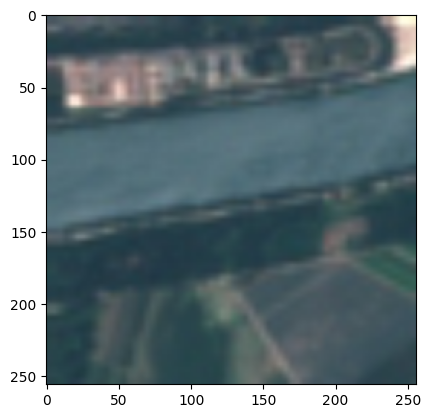

In [ ]:
plt.imshow(torch.transpose(train_set[22000][0].detach(),0,2))

In [ ]:
class GateSigmoid_GEN(torch.nn.Module):
    def __init__(self,C):
        super(GateSigmoid_GEN, self).__init__()
        self.p = torch.nn.Parameter(torch.ones((1,C,1,1)))
    
    def forward(self, x):
        return 1/(1+torch.exp(-x*self.p))

class GateSigmoid_DISC(torch.nn.Module):
    def __init__(self):
        super(GateSigmoid_DISC, self).__init__()
        self.p = torch.nn.Parameter(torch.ones((1)))
    
    def forward(self, x):
        return 1/(1+torch.exp(-x*self.p))

In [ ]:
class Generator(torch.nn.Module):
    def __init__(self, Q1, Q2, C):# B):
        super(Generator, self).__init__()

        self.Q1 = Q1
        self.Q2 = Q2
        #self.B = B
        self.norm = torch.nn.BatchNorm2d(C)
        self.conv1 = torch.nn.Conv2d(in_channels=C, out_channels=C*Q1, kernel_size=5, stride=1, padding=2)
        self.conv2 = torch.nn.Conv2d(in_channels=C*Q1, out_channels=C*Q2, kernel_size=5, stride=1, padding=2)
        self.act = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout2d(p=0.5)
        self.gate = GateSigmoid_GEN(C=3)
        self.flatten = torch.nn.Flatten()
        #self.fc1 = torch.nn.Linear(in_features=int(Q2*256*256),out_features=int(256*256), bias=True)#stride happens in 2 dimensions so for every conv layer with a stride of 2 the image shrinks by a factor of 4
        #self.unflatten = torch.nn.Unflatten(1, (1,256,256))
        self.prelu = torch.nn.PReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.convblock = torch.nn.Sequential(
            torch.nn.BatchNorm2d(C),
            torch.nn.Conv2d(in_channels=C*1, out_channels=C*Q1, kernel_size=5, stride=1, padding=2),
            torch.nn.Dropout2d(p=0.5),
            torch.nn.BatchNorm2d(C*Q1),
            torch.nn.PReLU(),
            torch.nn.Conv2d(in_channels=C*Q1, out_channels=C*1, kernel_size=5, stride=1, padding=2),
            
            #torch.nn.BatchNorm2d(1),
            #torch.nn.PReLU(),
            #torch.nn.ReLU(),
            #torch.nn.Flatten(),
            #torch.nn.Linear(in_features=int(Q2*256*256),out_features=int(256*256), bias=True),
            #torch.nn.Unflatten(1, (1,256,256)),
            #torch.nn.Sigmoid()#PSigmoid()
        )

    def forward(self, x):
        #x = self.convblock(x)
        x = self.convblock(x)
        deep_feature = self.convblock(x)
        output = self.gate(deep_feature)

        #output = self.convblock(deep_feature)
        #possibly add batchnorm at the end

        '''
        x = self.norm(x)
        x = self.conv1(x)
        x = self.dropout(x)
        x = self.act(x)
        deep_feature = self.conv2(x)
        x = deep_feature
        x = self.dropout(x)
        x = self.act(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.unflatten(x)
        output = self.sigmoid(x)
        '''
        # stack multiple conv layers
        return output, deep_feature


In [ ]:
class Mini_Generator(torch.nn.Module):
    def __init__(self, Q1, C):
        super(Mini_Generator, self).__init__()
        self.Q1 = Q1
        self.conv1 = torch.nn.Conv2d(in_channels=C, out_channels=C*Q1, kernel_size=5, stride=1, padding=2)
        self.conv2 = torch.nn.Conv2d(in_channels=Q1*C, out_channels=C, kernel_size=5, stride=1, padding=2)
        self.norm0 = torch.nn.BatchNorm2d(C)
        self.norm1 = torch.nn.BatchNorm2d(Q1*C)
        self.prelu = torch.nn.PReLU()
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout2d(p=0.2)
        self.gate = GateSigmoid_GEN(3)

    def forward(self, x):
        x = self.norm0(x)
        x = self.conv1(x)
        x = self.prelu(x)
        x = self.norm1(x)
        x = self.dropout(x)
        df = self.conv2(x)
        output = self.gate(df)
        return output, df


In [ ]:

class Discriminator(torch.nn.Module):
    def __init__(self, Q1, Q2, C):#, B):
        super(Discriminator, self).__init__()
        self.Q1 = Q1
        self.Q2 = Q2
        #self.B = B
        self.norm1 = torch.nn.BatchNorm2d(C*1)
        self.norm2 = torch.nn.BatchNorm2d(C*Q1)
        self.norm3 = torch.nn.BatchNorm2d(C*Q2)
        self.conv1 = torch.nn.Conv2d(in_channels=1*C, out_channels=C*Q1, kernel_size=5, stride=2, padding=2)
        self.conv2 = torch.nn.Conv2d(in_channels=C*Q1, out_channels=C*Q2, kernel_size=5, stride=2, padding=2)
        self.conv3 = torch.nn.Conv2d(in_channels=C*Q2, out_channels=C*Q1, kernel_size=5, stride=2, padding=2)
        self.conv4 = torch.nn.Conv2d(in_channels=C*Q1, out_channels=1, kernel_size=5, stride=2, padding=2)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = torch.nn.Dropout2d()
        #add dropout layer
        self.act = torch.nn.ReLU()
        self.flatten = torch.nn.Flatten()
        self.fc1 = torch.nn.Linear(in_features=4,out_features=2, bias=True)#stride happens in 2 dimensions so for every conv layer with a stride of 2 the image shrinks by a factor of 4
        self.prelu = torch.nn.PReLU()
        self.fc2 = torch.nn.Linear(2,1,True)
        self.sigmoid = torch.nn.Sigmoid()
        self.gate = GateSigmoid_DISC()

    def forward(self, x):
        x = self.norm1(x)
        x = self.conv1(x)
        x = self.dropout(x)
        x = self.pool(x)
        x = self.norm2(x)
        x = self.act(x)
        x = self.conv2(x)
        x = self.dropout(x)
        x = self.pool(x)
        x = self.norm3(x)
        x = self.act(x)
        x = self.conv3(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.pool(x)
        x = self.norm2(x)
        x = self.conv4(x)
        x = self.flatten(x)
        deep_feature = self.fc1(x)
        J_gan = self.prelu(deep_feature)
        J_gan = self.fc2(J_gan)
        J_gan = self.gate(J_gan)
        return J_gan, deep_feature



In [ ]:
def blur(t):
    x = torchvision.transforms.functional.gaussian_blur(img=t, kernel_size=17,sigma=15)
    return x

In [ ]:
def compress(t):
    x = torchvision.transforms.functional.resize(img=t, size=(128,128))
    return x

In [ ]:
def GANLoss(fake_disc, real_disc):
    loss = -torch.sum(torch.log(real_disc))-torch.sum(torch.log(1-fake_disc))
    return loss

def DISCLoss(fake_disc, real_disc):
    loss = -torch.sum(torch.log(real_disc))-torch.sum(torch.log(1-fake_disc))
    return loss

def GENLoss(fake_disc, real_disc):
    loss = (-torch.sum(torch.log(real_disc))-torch.sum(torch.log(fake_disc)))
    return loss


In [ ]:
### GPU type
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Sep  6 15:06:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.94       Driver Version: 516.94       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P4000       WDDM  | 00000000:00:05.0  On |                  N/A |
| 46%   35C    P8     8W / 105W |    231MiB /  8192MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!nvidia-smi -L

GPU 0: Quadro P4000 (UUID: GPU-cbfa8cc7-5459-9396-4d32-322c2f23aead)


In [ ]:
torch.cuda.is_available()

False

In [ ]:
# RAM memory availability
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 32.2 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: ignored

# Training Loop

In [ ]:
torch.cuda.get_device_name(0)

AssertionError: ignored

In [ ]:
def train(generator, discriminator, epochs, lr=0.0001, suffix="", dev="cuda", skip=1): #if the skip variable is set to 1, no generator batch is skipped.
    device = torch.device(dev)

    generator = generator.to(device)
    discriminator = discriminator.to(device)
    gen_optim = torch.optim.RMSprop(params=generator.parameters(), lr=lr)
    disc_optim = torch.optim.RMSprop(params=discriminator.parameters(), lr=lr)

    disc_plot = []
    gen_plot = []

    loss = torch.nn.BCELoss()
    
    df_len = len(train_set)
    B = df_len//train_loader.batch_size
    batchlen = train_loader.batch_size
    for epoch in tqdm(range(epochs)):
        disc_loss = 0
        gen_loss = 0
        gen_skip = 0
        for t,_ in tqdm(train_loader):
            x = blur(t)
            #x = x.float()#
            #t = t.float()#
            #for x, t in tqdm(data):

            ### Discriminator training 
            disc_optim.zero_grad()
            y,_ = generator(x.to(device))

            real_disc,_ = discriminator(t.to(device)) 
            fake_disc,_ = discriminator(y.to(device))
            real_label = torch.ones((batchlen,1), device=device)
            fake_label = torch.zeros((batchlen,1), device=device)

            J_real = loss(real_disc, real_label)
            J_real.backward()

            J_fake = loss(fake_disc, fake_label)
            J_fake.backward()

            disc_optim.step()

            J = (J_real.item() + J_fake.item())/2
            disc_loss += J
            disc_plot.append(J)

            gen_skip += 1
            
            if gen_skip != skip:
                continue
            elif gen_skip == skip:
                ### Generator training
                gen_optim.zero_grad()
                y,_ = generator(x.to(device))
                real_disc,_ = discriminator(t.to(device))
                fake_disc,_ = discriminator(y.to(device))

                real_label = torch.full((batchlen,1), 1., device=device)
                fake_label = torch.full((batchlen,1), 0., device=device)

                J_real = loss(fake_disc, real_label)
                J_real.backward()

                J_fake = loss(real_disc, fake_label)
                J_fake.backward()

                gen_optim.step()

                J = (J_real.item() + J_fake.item())/2
                gen_loss += J
                gen_plot.append(J)
                gen_skip = 0
        
                
        print(f"epoch: {epoch}\t Disc. Loss: {disc_loss/B:1.4f}\t Gen. Loss: {gen_loss/B:1.4f}\t Combined Loss: {((disc_loss/B)+ (gen_loss/B))/2:1.4f}")
        ### GPU type
        gpu_info = !nvidia-smi
        gpu_info = '\n'.join(gpu_info)
        if gpu_info.find('failed') >= 0:
          print('Not connected to a GPU')
        else:
          print(gpu_info)

        '''
        ### Saving models to Drive
        if math.isnan(disc_loss) == True:
            break
        elif math.isnan(gen_loss) == True:
            break
        else:
            torch.save(generator.state_dict(), f"/content/drive/My Drive/Colab Notebooks/Map_GAN_generator{suffix}.pth")
            torch.save(discriminator.state_dict(), f"/content/drive/My Drive/Colab Notebooks/Map_GAN_discriminator{suffix}.pth")
        '''

    plt.figure(figsize=(10,7))
    plt.plot(disc_plot,label="discriminator")
    plt.plot(gen_plot, label="generator")
    #plt.yscale("log")
    plt.legend()
    plt.show()

    return generator, discriminator

In [ ]:
### Train models
generator = Generator(8,8,3)
discriminator = Discriminator(8,8,3)

generator, discriminator = train(generator, discriminator, 10)

AssertionError: ignored

ModuleNotFoundError: ignored

In [ ]:
generator, discriminator = train(generator, discriminator, 10, skip=4)

AssertionError: ignored

In [ ]:
tens = torch.tensor([1], device="cuda")

AssertionError: ignored

In [ ]:
### Restore the models from Drive

generator = Generator(8,8,3)
generator.load_state_dict(torch.load("/content/drive/My Drive/Colab Notebooks/Map_GAN_generator.pth"))
generator.to(device)
discriminator = Discriminator(8,8,3)
discriminator.load_state_dict(torch.load("/content/drive/My Drive/Colab Notebooks/Map_GAN_discriminator.pth"))
discriminator.to(device)

Discriminator(
  (norm1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv2): Conv2d(24, 24, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv3): Conv2d(24, 24, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv4): Conv2d(24, 1, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.5, inplace=False)
  (act): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4, out_features=2, bias=True)
  (prelu): PReLU(num_parameters=1)
  (fc2): Linear(in_features=2, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (gate): GateSigmoid_DISC()
)

In [ ]:
### Mini Generator Training
mini_generator = Mini_Generator(32,3)
mini_generator, mini_discriminator = train(mini_generator, discriminator, 30, suffix="_mini")

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

RuntimeError: ignored

In [ ]:
generator, discriminator = train(generator, discriminator, 30)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

RuntimeError: ignored

In [ ]:
(6*4.5+5*5.5+6*4.75+6*5)/23

4.913043478260869

In [ ]:
for x,_ in train_loader:
    print(x.shape)

torch.Size([128, 3, 256, 256])
torch.Size([128, 3, 256, 256])
torch.Size([128, 3, 256, 256])
torch.Size([128, 3, 256, 256])
torch.Size([128, 3, 256, 256])
torch.Size([128, 3, 256, 256])
torch.Size([128, 3, 256, 256])
torch.Size([128, 3, 256, 256])
torch.Size([128, 3, 256, 256])
torch.Size([128, 3, 256, 256])
torch.Size([128, 3, 256, 256])
torch.Size([128, 3, 256, 256])
torch.Size([128, 3, 256, 256])
torch.Size([128, 3, 256, 256])
torch.Size([128, 3, 256, 256])


KeyboardInterrupt: ignored

In [ ]:

def test_model(generator, C, n):
    generator.to("cpu")
    map = torch.zeros((n, C, 256, 256))
    blurred_map = torch.zeros((n, C, 256, 256))
    reconstructed_map = torch.zeros((n, C, 256, 256))
    gen_deepfeet = torch.zeros((n, C, 256, 256))
    for c, i in enumerate(np.random.randint(0, len(train_set), (n))):
        map[c] = train_set[i][0]
        blurred_map[c] = blur(train_set[i][0])
        with torch.no_grad():
            reconstructed_map[c], gen_deepfeet[c] = generator(torch.unsqueeze(train_set[i][0],0))
    return map, blurred_map, reconstructed_map, gen_deepfeet

In [ ]:
map, blur_map, gen_map, gen_df = test_model(generator,3, 120)

In [ ]:
from ignite.metrics import SSIM
def performance(img,gen_img, k1=0.01, k2=0.03):
    cosine = torch.nn.functional.cosine_similarity(torch.flatten(img),torch.flatten(gen_img))
    return cosine

ModuleNotFoundError: ignored

In [ ]:
n=1

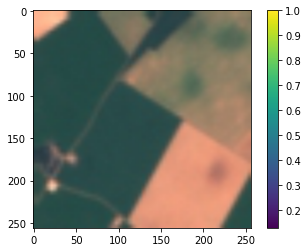

In [ ]:
plt.imshow(torch.transpose(map.detach()[n],0,2))
plt.colorbar()

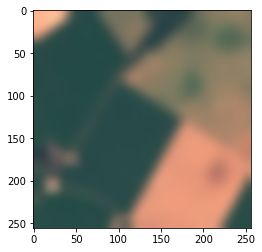

In [ ]:
plt.imshow(torch.transpose(blur_map.detach()[n],0,2))

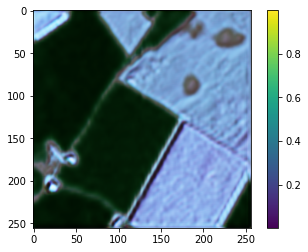

In [ ]:
plt.imshow(torch.transpose(gen_map.detach()[n],0,2))
plt.colorbar()

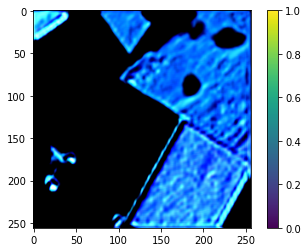

In [ ]:
plt.imshow(torch.transpose(gen_df.detach()[n],0,2))
plt.colorbar()

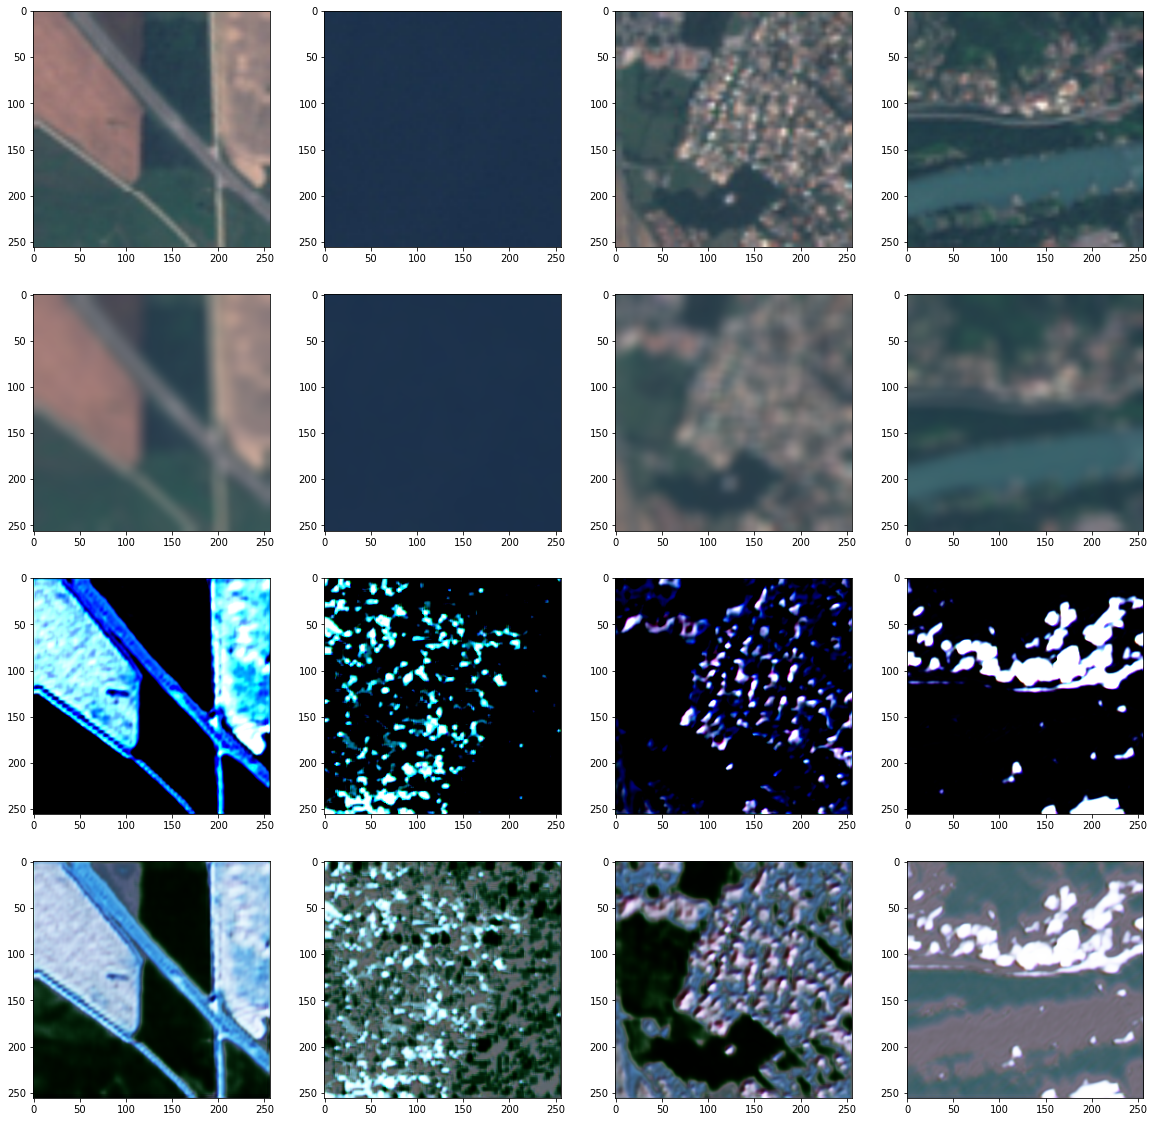

In [ ]:
im_n = 100
fig, (ax) = plt.subplots(4,4, figsize=(20,20))
im1=ax[0,0].imshow(torch.transpose(map.detach()[im_n],0,2))
ax[1,0].imshow(torch.transpose(blur_map.cpu().detach()[im_n],0,2))
ax[2,0].imshow(torch.transpose(gen_df.cpu().detach()[im_n],0,2))
im2=ax[3,0].imshow(torch.transpose(gen_map.cpu().detach()[im_n],0,2))
ax[0,1].imshow(torch.transpose(map.cpu().detach()[im_n+1],0,2))
ax[1,1].imshow(torch.transpose(blur_map.cpu().detach()[im_n+1],0,2))
ax[2,1].imshow(torch.transpose(gen_df.cpu().detach()[im_n+1],0,2))
ax[3,1].imshow(torch.transpose(gen_map.cpu().detach()[im_n+1],0,2))
ax[0,2].imshow(torch.transpose(map.cpu().detach()[im_n+2],0,2))
ax[1,2].imshow(torch.transpose(blur_map.cpu().detach()[im_n+2],0,2))
ax[2,2].imshow(torch.transpose(gen_df.cpu().detach()[im_n+2],0,2))
ax[3,2].imshow(torch.transpose(gen_map.cpu().detach()[im_n+2],0,2))
ax[0,3].imshow(torch.transpose(map.cpu().detach()[im_n+3],0,2))
ax[1,3].imshow(torch.transpose(blur_map.cpu().detach()[im_n+3],0,2))
ax[2,3].imshow(torch.transpose(gen_df.cpu().detach()[im_n+3],0,2))
ax[3,3].imshow(torch.transpose(gen_map.cpu().detach()[im_n+3],0,2))



In [ ]:
import plotly
import plotly.express as px

with torch.no_grad():
    fake, fake_df = discriminator(gen_map.unsqueeze(dim=1).to(device))
    real, real_df = discriminator(map.unsqueeze(dim=1).to(device))
    alt, alt_df = discriminator(gen_df.unsqueeze(dim=1).to(device))

fake_df_x = fake_df.cpu().detach()[:,0]
fake_df_y = fake_df.cpu().detach()[:,1]
fake = np.squeeze(fake.cpu().detach(),1)
real_df_x = real_df.cpu().detach()[:,0]
real_df_y = real_df.cpu().detach()[:,1]
real = np.squeeze(real.cpu().detach(),1)
alt_df_x = alt_df.cpu().detach()[:,0]
alt_df_y = alt_df.cpu().detach()[:,1]
alt = np.squeeze(alt.cpu().detach(),1)
df_x = np.concatenate((fake_df_x, real_df_x, alt_df_x))
df_y = np.concatenate((fake_df_y, real_df_y, alt_df_y))
j_disc = np.concatenate((fake, real, alt))
disc_loss = np.concatenate((np.zeros(120),np.ones(120),-0.25*np.ones(120)))



fig = px.scatter_3d(x=df_x, y=df_y, z=j_disc, color=disc_loss)
fig.show()